# Plots from AWS archived HRRR



```{image} ../thumbnails/aws.png
:alt: ECMWF logo
:width: 200px
```

---

## Overview
Amazon Web Services (AWS) keeps an archive of operational High Resolution Rapid Refresh (HRRR) forecast cycles stored on their cloud system. We will use the `Herbie` package, which is specifically designed to grab model data from cloud archives, to grab HRRR data from the day of the event. We can then visualize HRRR's convective parameters that come pre-processed in HRRR output files.

One key difference between this archive and the Google Cloud ERA5 archive is the storage method. Google Cloud ERA5 is in analysis ready cloud optimized (ARCO) Zarr formatted files, which makes pointing to the archive as easy as pointing to one file and then subsetting it later. On the other hand, this archive was setup before ARCO formatting became popular, so each output of each run is in its own separate grib file. To analyze over a longer time period, we first read the files in individually, then use `xarray` to concatenate them into one useful dataset.

This notebook focuses on:

1. Accessing AWS HRRR data with Herbie
1. Manipulating the data into one easy to work with xarray dataset object
2. Plotting a two-pannel temp and dewpoint plot
1. Plotting a four-pannel animation of CAPE, 0-1 km storm relative helicity, 0-3km storm relative helicity, and significant tornado parameter
2. Plotting HRRR modeled sounding using `SounderPy`


   

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Understanding of HRRR](https://rapidrefresh.noaa.gov/hrrr/) | Necessary | |
| MatPlotLib | Recommended | |
| Herbie | Recommended | |
| SounderPy | Helpful | |


- **Time to learn**: 10 minutes
- **System requirements**:
    - >5 GB of system memory (Original load of HRRR requires system memory, files are deleted after being read in)

---

## Imports
--------------------------------

In [4]:
import xarray as xr
import cfgrib
import s3fs
import metpy
import metpy.calc as mpcalc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.cm as mplcm
import matplotlib
from matplotlib.colors import Normalize
from matplotlib.animation import ArtistAnimation
import pandas as pd
from metpy.units import units
from metpy.plots import USCOUNTIES, ctables
from metpy.plots import Hodograph, SkewT
from datetime import datetime as dt
import cfgrib
import fsspec
from datetime import timedelta
from herbie import Herbie
import os
import sounderpy as spy
import pyproj
import cartopy.crs as ccrs
import cartopy.feature as cfeat


## ---------------------------------- SOUNDERPY ----------------------------------- ##
##          Vertical Profile Data Retrieval and Analysis Tool For Python            ##
##                    v3.0.9 | August 2025 | (C) Kyle J Gillett                     ##
##                 Docs: https://kylejgillett.github.io/sounderpy/                  ##
## --------------------- THANK YOU FOR USING THIS PACKAGE! ------------------------ ##



## Overview of Herbie

Herbie is designed to allow quick and easy access to a variety of forecast model output, both current and archived. Herbie can access all of the US NCEP models, the ECMWF IFS and AIFS models, and the Canadian HRDPS model. Herbie intakes the selected model and model forecast run, and will do the heavy lifing to find and download the model data needed. 


## Select the model forecast cycle and duration of forecast hours of interest

The two events, the Merrimack County NH EF1 and the Central NJ tornado family of 2021 have been pre set. To select the Merrimack County tornado, set `ex_opt=1`. To select the Central NJ tornado family of 2021, set `ex_opt=2`. You can also select an event of your own choosing, just keep in mind HRRR only goes back to 2014.

For this example, we look at HRRR from 18z to 00z the day of the event in the interest of limiting the size of files downloaded.

In [5]:
#=====================set to select case=================
ex_opt=2
#========================================================

if ex_opt==1:
    date='2018-05-04' # in YYYYMMDD format
    hour='18' #run hour
    max_fh=6 #how many hours are in the hrrr. HRRR runs to 48 hrs on synoptic times and 18 hours on non synptic times.
    dateobj=date+' '+hour+':00'

elif ex_opt==2:
    
    date='2021-07-29' # in YYYYMMDD format
    hour='18' #run hour
    max_fh=6 #how many hours are in the hrrr. HRRR runs to 48 hrs on synoptic times and 18 hours on non synptic times.
    dateobj=date+' '+hour+':00'

## Use Herbie to access and open HRRR data

Herbie will download the data locally when it accesses it. Setup a junk folder to temporarily store the data, then remove the data after we read it into an xarray dataset

In [6]:
#make a junk directory to temporarily store hrrr files from herbie

if not os.path.exists("junk"):
    os.mkdir("junk")

#loop over forecast hours to download each hour
datasets=[[],[],[],[],[],[],[],[]]
for hr in range(max_fh+1):
    print(hr)

    #get data w/ Herbie
    H = Herbie(
        f'{dateobj}',
        model="hrrr",
        product="prs",
        fxx=hr,
        priority=["aws"],
        save_dir="junk"
    )
    
    #read file into an xarray. Only chose vars with isobaric coordinates
    ds_isobaric = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'isobaricInhPa'
                                                        }},
                    remove_grib=True)   # load into xarray

    ds_helicity = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGroundLayer',
                                                        'shortName':'hlcy'}},
                    remove_grib=True)   # load into xarray 
    ds_Ushear06 = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGroundLayer',
                                                        'shortName':'vucsh'}},
                    remove_grib=True)   # load into xarray
    ds_Vshear06 = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGroundLayer',
                                                        'shortName':'vvcsh'}},
                    remove_grib=True)   # load into xarray

    ds_temps = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGround',
                                                        'shortName':'2t'}},
                    remove_grib=True)   # load into xarray 
    ds_dewpoint = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGround',
                                                        'shortName':'2d'}},
                    remove_grib=True)   # load into xarray

    ds_sbcape = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface',
                                                        'shortName':'cape'}},
                    remove_grib=True)
    ds_sbcin = H.xarray(backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface',
                                                        'shortName':'cin'}},
                    remove_grib=True)

    
    datasets[0].append(ds_isobaric)
    datasets[1].append(ds_helicity)
    datasets[2].append(ds_Ushear06)
    datasets[3].append(ds_Vshear06)
    datasets[4].append(ds_temps)
    datasets[5].append(ds_dewpoint)
    datasets[6].append(ds_sbcape)
    datasets[7].append(ds_sbcin)

# Combine along forecast time dimension
ds_iso = xr.concat(datasets[0], dim='time')
ds_hlcy = xr.concat(datasets[1], dim='time')
ds_Ushr = xr.concat(datasets[2], dim='time')
ds_Vshr = xr.concat(datasets[3], dim='time')
ds_t = xr.concat(datasets[4], dim='time')
ds_td = xr.concat(datasets[5], dim='time')
ds_cape = xr.concat(datasets[6], dim='time')
ds_cin = xr.concat(datasets[7], dim='time')

0
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-29 18:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [junk/hrrr/20210729]
1
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-29 18:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
2
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-29 18:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
3
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-29 18:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
4
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-29 18:00 UTC F04 ┊ GRIB2 @ aws ┊ IDX @ aws
5
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-29 18:00 UTC F05 ┊ GRIB2 @ aws ┊ IDX @ aws
6
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2021-Jul-29 18:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


## Delete junk directory and all HRRR files

Cells inside a Jupyter Notebook can execute linux commands if command is proceeded by an exclamation point( ! )

In [7]:
!rm -rf ./junk

## Plot two pannel plot of temp and dewpoint

2021-07-29T18:00:00.000000000
2021-07-29T18:00:00.000000000
2021-07-29T18:00:00.000000000
2021-07-29T18:00:00.000000000
2021-07-29T19:00:00.000000000
2021-07-29T19:00:00.000000000
2021-07-29T20:00:00.000000000
2021-07-29T20:00:00.000000000
2021-07-29T21:00:00.000000000
2021-07-29T21:00:00.000000000
2021-07-29T22:00:00.000000000
2021-07-29T22:00:00.000000000
2021-07-29T23:00:00.000000000
2021-07-29T23:00:00.000000000
2021-07-30T00:00:00.000000000
2021-07-30T00:00:00.000000000


2021-07-29T18:00:00.000000000
2021-07-29T18:00:00.000000000


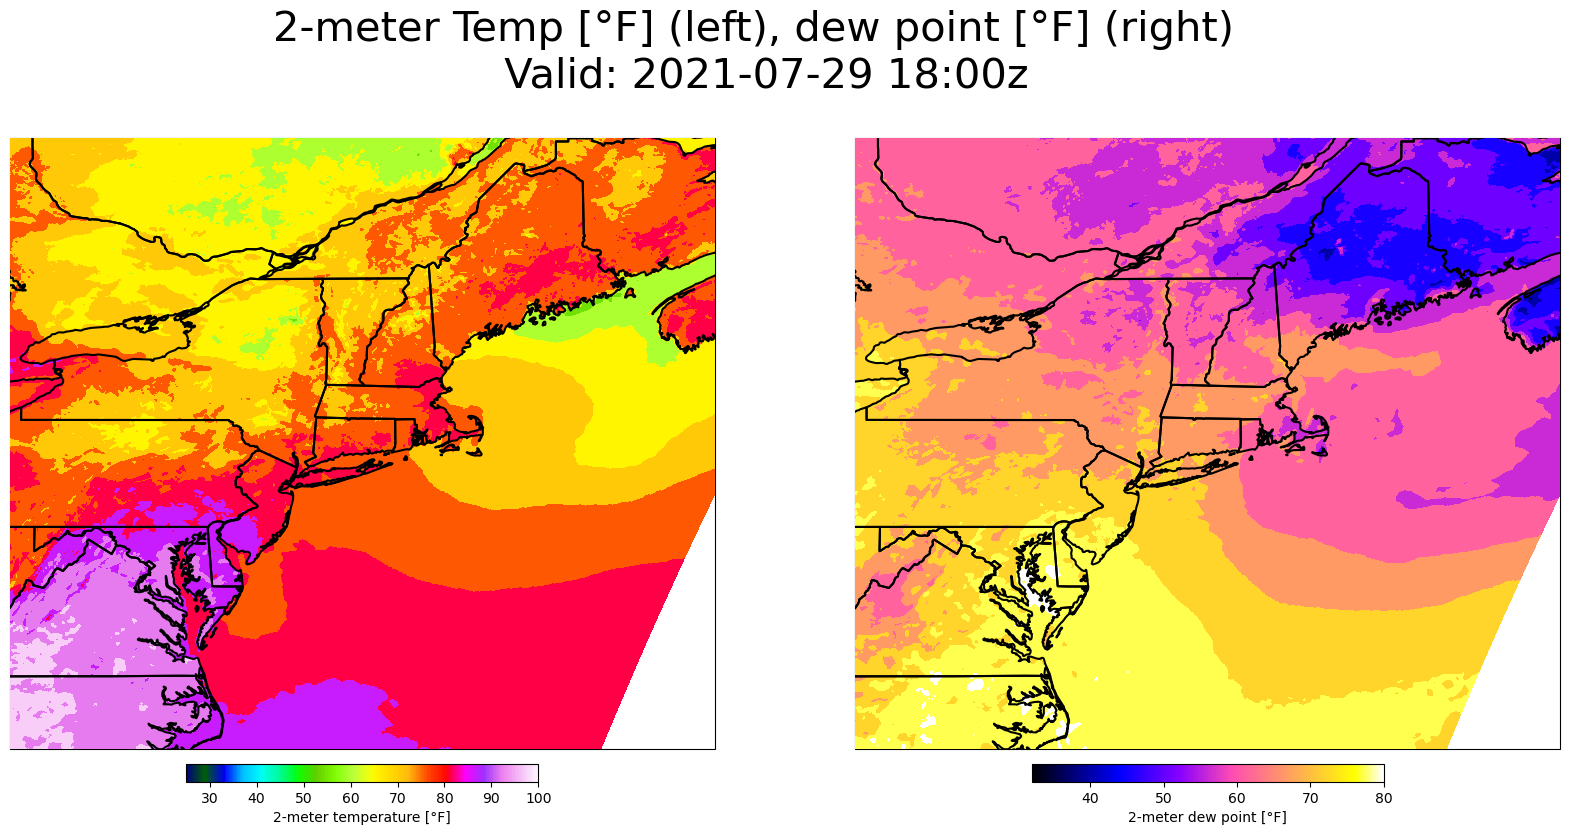

In [8]:

# setup map projection. For this example, we setup a center of the plot to cover the Northeast as a whole
cLat = 42.0                   # central latitude of the projection
cLon = -73.5                   # central longitude of the projection
    # create the projection and an axis object
proj=ccrs.PlateCarree(central_longitude=cLon)

#settings for animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100
plt.ioff()

#determine the number of time steps
ntimes=len(ds_t.time)

#declare the figure item
figanim, ax=plt.subplots(1,2,figsize=(20,10), subplot_kw={'projection':proj})
ax0 = ax[0]
ax1 = ax[1]

#setup a colorbar, need to create dummy scalar mappable to plot colorbar
normt = plt.Normalize(vmin=25, vmax=100)
normtd = plt.Normalize(vmin=32, vmax=80)
cmapt = 'gist_ncar'
cmaptd = 'gnuplot2'

smt = mplcm.ScalarMappable(norm=normt, cmap=cmapt)
smt.set_array([])

smtd = mplcm.ScalarMappable(norm=normtd, cmap=cmaptd)
smtd.set_array([])

# add colorbars to figure
cbar = figanim.colorbar(smt, ax=ax0, orientation='horizontal', shrink=0.5, pad=0.02)
cbar.set_label('2-meter temperature [°F]')
cbar1 = figanim.colorbar(smtd, ax=ax1, orientation='horizontal', shrink=0.5, pad=0.02)
cbar1.set_label('2-meter dew point [°F]')

#define lats and lons 
lats=ds_t.latitude.values
lons=ds_t.longitude.values


def animate(t):
    ax0.cla()
    ax1.cla()
    
    mtime=np.copy(t)
    print(f'Frame {mtime}/{ntimes-1}',end='\r')

    #======code for the temp plot==============

    #select temp at time step, attach units
    t=ds_t.isel(time=mtime)

    tk=t.t2m.values*units.K
    #convert temp to celsius
    tf=tk.to('degF')

    #pull current time string
    current_time=t.valid_time.values
    print(current_time)

    
    
    # add some nice map features, zoom in on area of interest
    ax[0].set_extent([-80,-65,48,35])
    
    ax0.add_feature(cfeat.LAND.with_scale('10m'),color='gray')
    ax0.add_feature(cfeat.STATES.with_scale('10m'),edgecolor='black', linewidth=1.5,zorder=6)

    
    #plot 2-m temp
    levs=np.arange(25,100,5)
    cm = ax0.contourf(lons, lats, tf,levels=levs,cmap=cmapt, extend='max',transform=ccrs.PlateCarree(),zorder=5)

    #==========code for the dewpoint plot=================
    #select dewpoint at time step, attach units
    td=ds_td.isel(time=mtime)

    tdk=td.d2m.values*units.K
    #convert temp to celsius
    tdf=tdk.to('degF')

    #pull current time string
    current_time=t.valid_time.values
    print(current_time)

    
    
    # add some nice map features, zoom in on area of interest
    ax1.set_extent([-80,-65,48,35])
    
    ax1.add_feature(cfeat.LAND.with_scale('10m'),color='gray')
    ax1.add_feature(cfeat.STATES.with_scale('10m'),edgecolor='black', linewidth=1.5,zorder=6)

    
    #plot 2-m dewpoint
    levs=np.arange(32,80,5)
    cm = ax1.contourf(lons, lats, tdf,levels=levs,cmap=cmaptd, extend='max',transform=ccrs.PlateCarree(),zorder=5)

    time=dt.strptime(str(current_time)[:16], "%Y-%m-%dT%H:%M")
    timeStr=time.strftime('%Y-%m-%d %H:%Mz')
    title=f'2-meter Temp [°F] (left), dew point [°F] (right) \n Valid: {timeStr}'
    plt.suptitle(title, fontsize=30)
    

anim=matplotlib.animation.FuncAnimation(figanim, animate, frames=ntimes)
anim
                  



## Plot 4-pannel view of 0-1km SRH, 0-3km SRH, SBCAPE, significant tornado parameter

In [18]:
plt.close()
# setup map projection. For this example, we setup a center of the plot to cover the Northeast as a whole
cLat = 42.0                   # central latitude of the projection
cLon = -73.5                   # central longitude of the projection
    # create the projection and an axis object
proj=ccrs.PlateCarree(central_longitude=cLon)

#settings for animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100
plt.ioff()

#determine the number of time steps
ntimes=len(ds_t.time)

#declare the figure item
figanim, ax=plt.subplots(2,2,figsize=(12,12), subplot_kw={'projection':proj},constrained_layout=True)
ax0 = ax[0,0]
ax1 = ax[0,1]
ax2 = ax[1,0]
ax3 = ax[1,1]

#setup a colorbar, need to create dummy scalar mappable to plot colorbar
norm_srh = plt.Normalize(vmin=0, vmax=500)
norm_cape = plt.Normalize(vmin=500, vmax=4500)
norm_STP = plt.Normalize(vmin=0.5, vmax=10)
cmap_srh = 'tab20c_r'
cmap_cape = 'plasma'
cmap_STP = 'turbo'

sm_srh = mplcm.ScalarMappable(norm=norm_srh, cmap=cmap_srh)
sm_srh.set_array([])

sm_cape = mplcm.ScalarMappable(norm=norm_cape, cmap=cmap_cape)
sm_cape.set_array([])

sm_STP = mplcm.ScalarMappable(norm=norm_STP, cmap=cmap_STP)
sm_STP.set_array([])


# add colorbars to corresponding plots
cbar = figanim.colorbar(sm_srh, ax=ax0, orientation='horizontal', shrink=0.5, pad=0.02)
cbar.set_label('0-1 km Storm Relative Helicity [m2/s2]')
cbar1 = figanim.colorbar(sm_srh, ax=ax1, orientation='horizontal', shrink=0.5, pad=0.02)
cbar1.set_label('0-3 km Storm Relative Helicity [m2/s2]')
cbar2 = figanim.colorbar(sm_cape, ax=ax2, orientation='horizontal', shrink=0.5, pad=0.02)
cbar2.set_label('Surface BAsed CAPE [J/kg]')
cbar3 = figanim.colorbar(sm_STP, ax=ax3, orientation='horizontal', shrink=0.5, pad=0.02)
cbar3.set_label('Significant Tornado Parameter')

#define lats and lons 
lats=ds_t.latitude.values
lons=ds_t.longitude.values


def animate(t):
    ax0.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    
    mtime=np.copy(t)
    print(f'Frame {mtime}/{ntimes-1}',end='\r')

    #======code for 0-1km srh plot==============

    #select 0-1 km SRH, subset to time step
    srh01=ds_hlcy.sel(heightAboveGroundLayer=1000)
    srh01_sel=srh01.isel(time=mtime).hlcy

    #pull current time string
    current_time=srh01_sel.valid_time.values
    print(current_time)

    
    
    # add some nice map features, zoom in on area of interest
    ax0.set_extent([-80,-65,48,35])
    ax0.set_title('0-1 km Storm Relative Helicity')
    
    ax0.add_feature(cfeat.LAND.with_scale('10m'),color='gray')
    ax0.add_feature(cfeat.STATES.with_scale('10m'),edgecolor='black', linewidth=1.5,zorder=6)

    
    #plot 0-1km srh
    levs=np.arange(0,400,25)
    cm = ax0.contourf(lons, lats,srh01_sel,levels=levs,cmap=cmap_srh, extend='max',transform=ccrs.PlateCarree(),zorder=5)

    #======code for 0-3km srh plot==============

    #select 0-1 km SRH, subset to time step
    srh03=ds_hlcy.sel(heightAboveGroundLayer=3000)
    srh03_sel=srh03.isel(time=mtime).hlcy
    
    # add some nice map features, zoom in on area of interest
    ax1.set_extent([-80,-65,48,35])
    ax1.set_title('0-3 km Storm Relative Helicity')
    
    ax1.add_feature(cfeat.LAND.with_scale('10m'),color='gray')
    ax1.add_feature(cfeat.STATES.with_scale('10m'),edgecolor='black', linewidth=1.5,zorder=6)

    
    #plot 0-1km srh
    levs=np.arange(0,400,25)
    cm = ax1.contourf(lons, lats,srh03_sel,levels=levs,cmap=cmap_srh, extend='max',transform=ccrs.PlateCarree(),zorder=5)

    #==========code for SBCAPE plot=================
    #select cape at time step
    cape=ds_cape.isel(time=mtime).cape
    cin =ds_cin.isel(time=mtime).cin
  
    # add some nice map features, zoom in on area of interest
    ax2.set_extent([-80,-65,48,35])
    ax2.set_title('Surface Based CAPE')
    
    ax2.add_feature(cfeat.LAND.with_scale('10m'),color='gray')
    ax2.add_feature(cfeat.STATES.with_scale('10m'),edgecolor='black', linewidth=1.5,zorder=6)

    
    #plot cape
    levs=np.arange(500,4500,500)
    cm = ax2.contourf(lons, lats, cape,levels=levs,cmap=cmap_cape, extend='max',transform=ccrs.PlateCarree(),zorder=5)

    #plot cin as hatched >25 J/kg
    hatch = ax2.contourf(lons,lats, cin, levels=[cin.min(),-25],colors='none', hatches=['/\/\/\/\/\/'])  # Hatching
    CL=ax2.contour(lons,lats,cin,levels=[-25],colors='black')

    time=dt.strptime(str(current_time)[:16], "%Y-%m-%dT%H:%M")
    timeStr=time.strftime('%Y-%m-%d %H:%Mz')
    title=f'2-meter Temp [°F] (left), dew point [°F] (right) \n Valid: {timeStr}'
    plt.suptitle(title)

     #==========code for STP plot=================
    #STP needs sbcape, lcl height, 0-1km srh and 0-6km shear. Read in 0-6 shear, estimate LCL height using 2-m temp and dew point
    bsU06=ds_Ushr.isel(time=mtime)
    bsV06=ds_Vshr.isel(time=mtime)
    t=ds_t.isel(time=mtime)
    td=ds_td.isel(time=mtime)

    #calculate the total shear from u and v components
    bs06=mpcalc.wind_speed(bsU06.vucsh.values*units('m/s'),bsV06.vvcsh.values*units('m/s'))

    #estimate LCL height from 2-m temp and dewpoint using lcl hgt (m) ~ 125*(T-Td)
    lclhgt=125*(t.t2m.values-td.d2m.values)

    #attach units to everything being fed into metpy
    srh01=srh01_sel.values*units('m2/s2')
    cape=cape.values*units('J/kg')
    lclhgt=lclhgt*units.m

    #calculate STP using metpy
    STP=mpcalc.significant_tornado(cape, lclhgt, srh01, bs06)
    
    # add some nice map features, zoom in on area of interest
    ax3.set_extent([-80,-65,48,35])
    ax3.set_title('Significant Tornado Parameter')
    
    ax3.add_feature(cfeat.LAND.with_scale('10m'),color='gray')
    ax3.add_feature(cfeat.STATES.with_scale('10m'),edgecolor='black', linewidth=1.5,zorder=6)
   
    #plot STP
    levs=np.arange(0.5,10.5,0.5)
    cm = ax3.contourf(lons, lats, STP,levels=levs,cmap=cmap_STP, extend='max',transform=ccrs.PlateCarree(),zorder=5)

    time=dt.strptime(str(current_time)[:16], "%Y-%m-%dT%H:%M")
    timeStr=time.strftime('%Y-%m-%d %H:%Mz')
    title=f'Severe Convective Parameters \n Valid: {timeStr}'
    plt.suptitle(title, fontsize=20)

anim=matplotlib.animation.FuncAnimation(figanim, animate, frames=ntimes)
anim
                  



2021-07-29T18:00:00.000000000
2021-07-29T18:00:00.000000000
2021-07-29T19:00:00.000000000
2021-07-29T20:00:00.000000000
2021-07-29T21:00:00.000000000
2021-07-29T22:00:00.000000000
2021-07-29T23:00:00.000000000
2021-07-30T00:00:00.000000000


## Overview of the SounderPy Package

SounderPy is designed to be a one-stop-shop for anything soundings related. SounderPy was created by Kyle Gillett out of Central Michigan University. SounderPy allows for generation of nice, compact soundings from a variety of sources, including observed rawindsondes, soundings from reanalysis models such as RAP, ERA5, and NCAR reanalyses, as well as the option to input your own custom data using a dictionary.

Although SounderPy's functionality allows for plotting ERA5 reanalysis on its own, it requires the user have an ECMWF Climate Data Store API setup. We skip the hassle of doing that by using the ERA5 hosted on Google Cloud.

[**You can view the SounderPy documentation here**](https://kylejgillett.github.io/sounderpy/about.html)

## Select a lat/lon location to pull a sounding at, and find the HRRR gridpoint nearest to that location

In [10]:
plt.close()
lat=40
lon=-75+360
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

x_dist, y_dist = projection.transform_point(lon, lat, ccrs.PlateCarree())

#convert from distance from the center to grid points from the center assuming HRRR's 3km grid spacing
x_gpdist,y_gpdist=x_dist/3000,y_dist/3000

#HRRR has 900 grid points in the east/west (x) direction and 530 grid points in the north south (y) direction. find grid point of interest
x_gp=900+x_gpdist
y_gp=530+y_gpdist

#ensure grid point is in HRRR domain
if x_gp<0 or x_gp>1799:
    raise ValueError('Selected longitude point not in HRRR domain')
if y_gp<0 or y_gp>1059:
    raise ValueError('Selected latitude point not in HRRR domain')


## Subset the data to the point selected and forecast hour of interest

In [11]:
#select a forecast hour time using ds.isel
ds_sel=ds_iso.isel(time=3)

#subset to point of interest, round to nearest grid point
ds_sub=ds_sel.sel(x=round(x_gp),y=round(y_gp))

## Create a clean dictionary object to input custom data into SounderPy, then plot the sounding

Sounderpy allows for custom data entry through a `clean_data` dictionary. This dictionary was constructed using the example code in the SounderPy documentation.

> SOUNDING PLOTTER FUNCTION
  ---------------------------------


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


    > COMPLETE --------
    > RUNTIME: 00:00:13


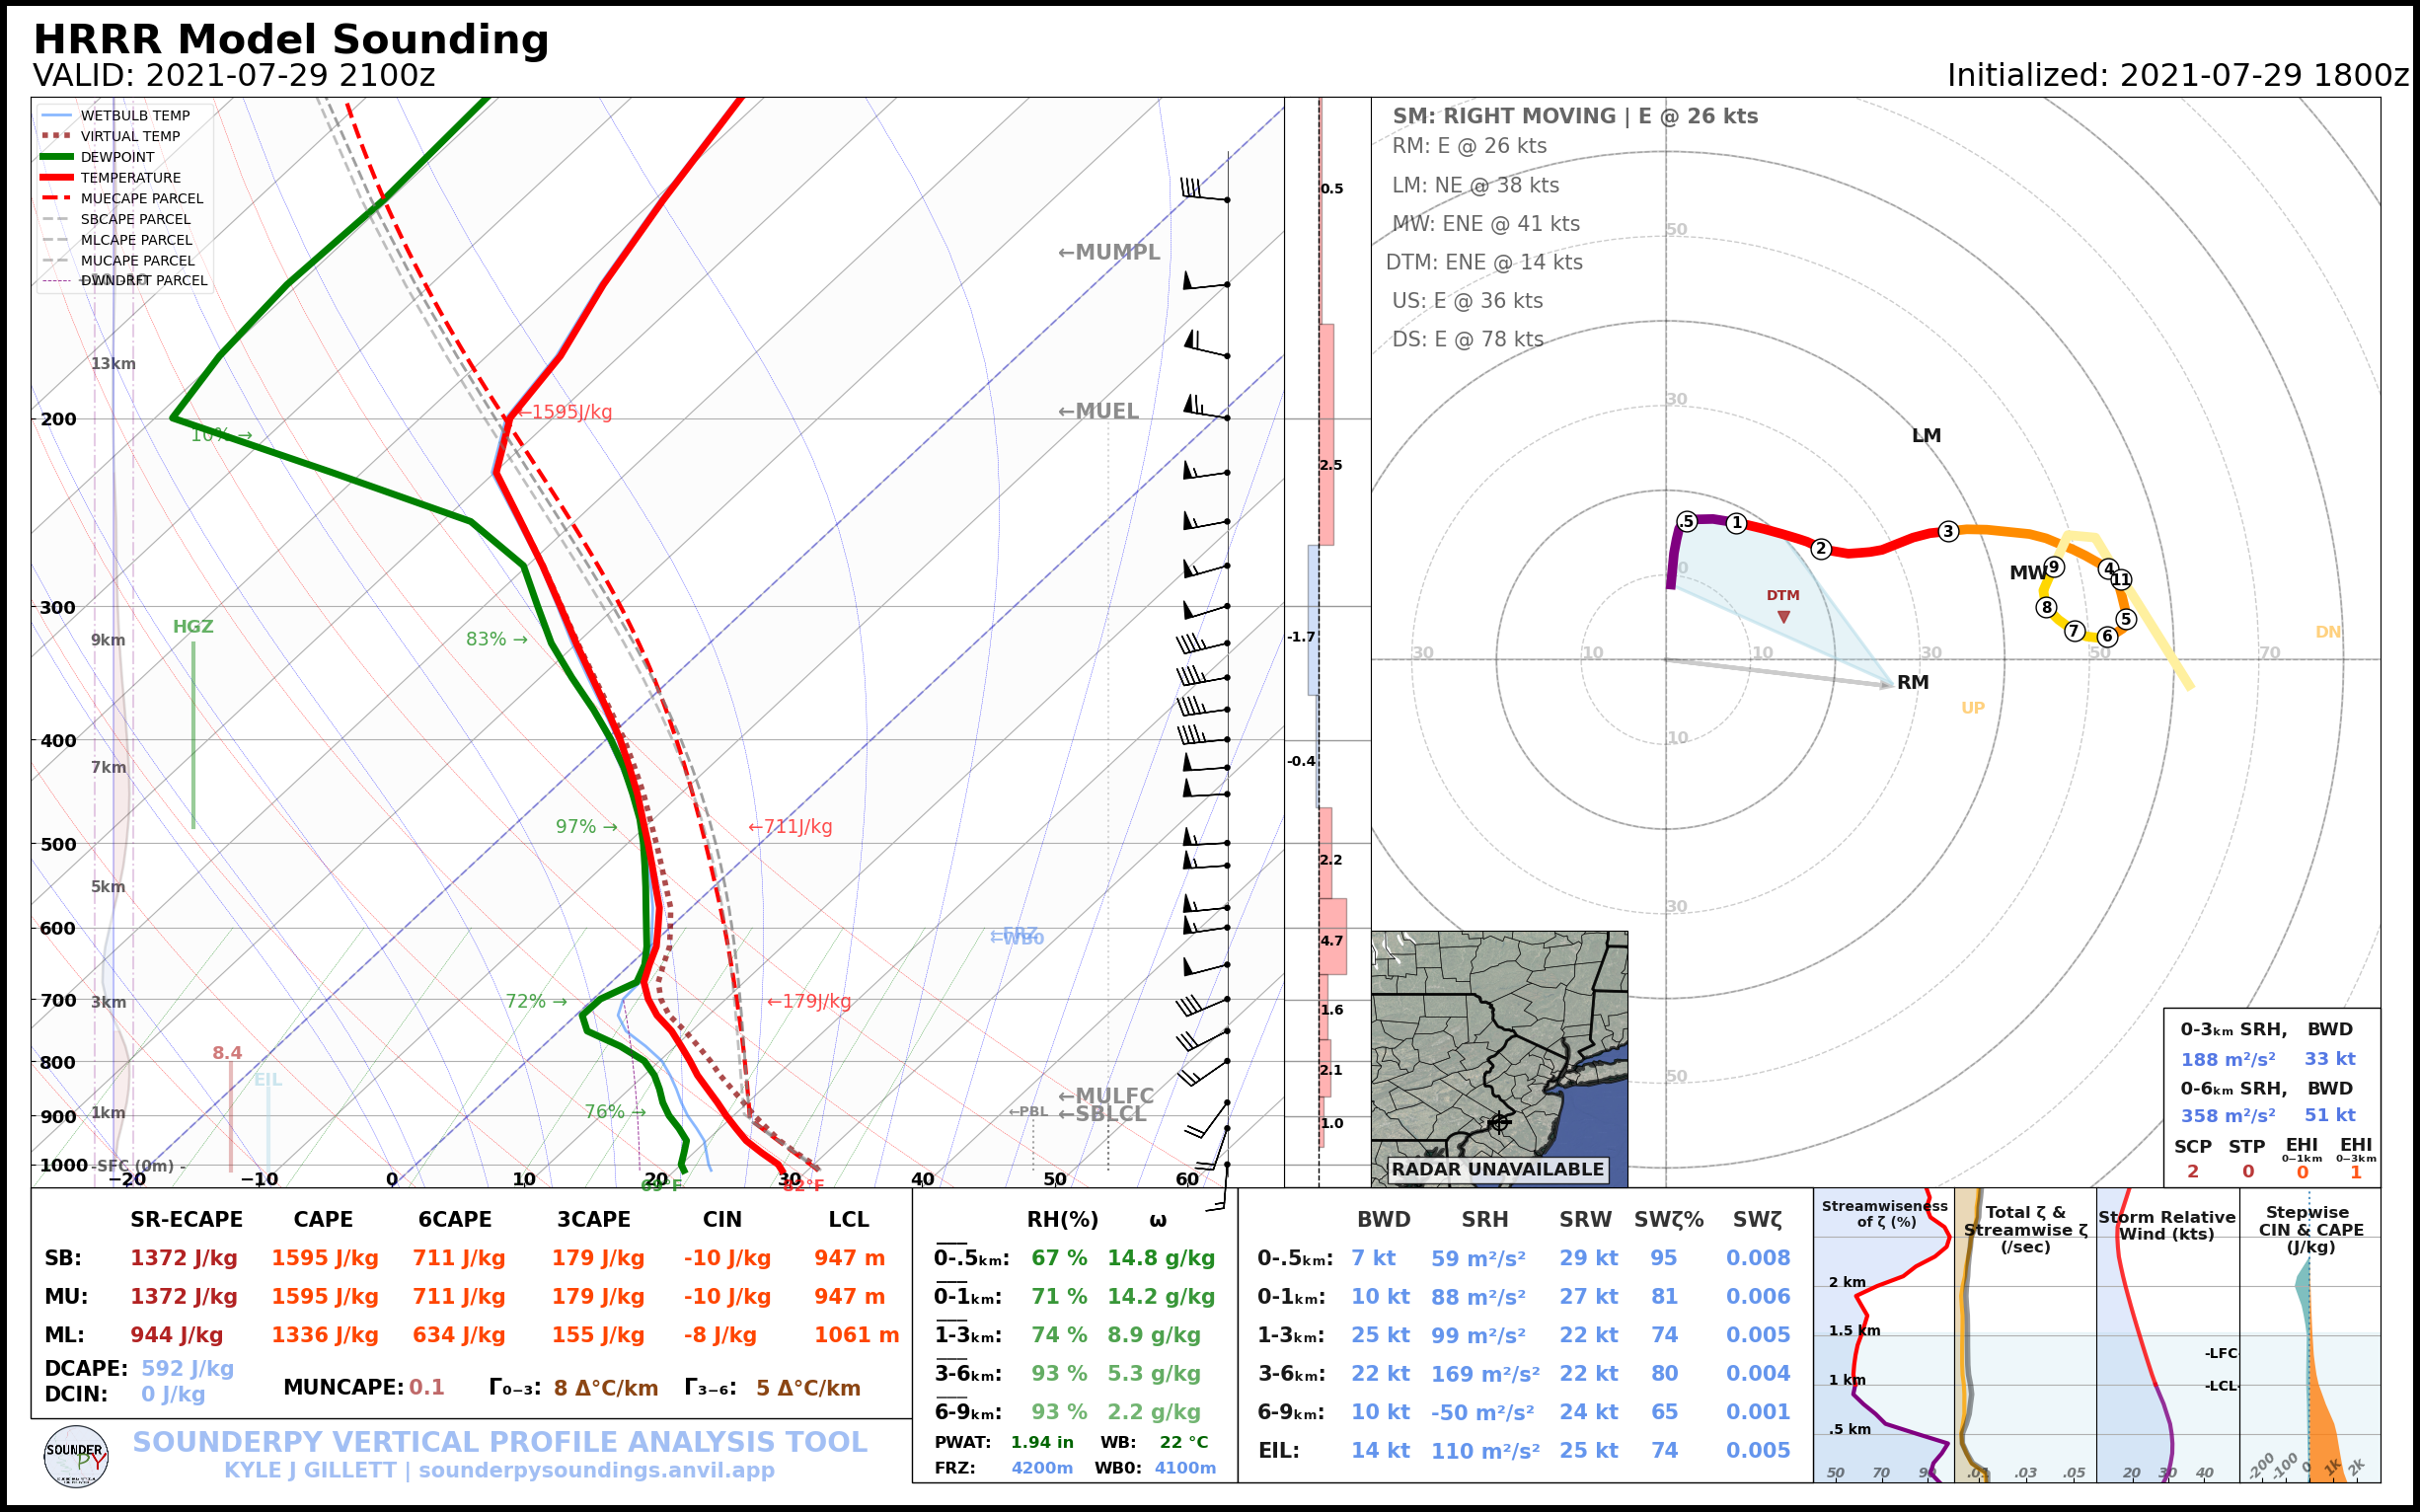

In [12]:
#convert the hrrr time format to a nicer format
current_time=ds_sub.valid_time.values
time=dt.strptime(str(current_time)[:16], "%Y-%m-%dT%H:%M")
timeStr=time.strftime('%Y-%m-%d %H%Mz')
saveTime=time.strftime('%Y-%m-%d_%H%M')
initTime=dt.strptime(str(ds_sub.time.values)[:16], "%Y-%m-%dT%H:%M")
initStr=initTime.strftime('%Y-%m-%d %H%Mz')

# declare the clean_data dictionary, leave it empty for the moment
clean_data = {}

# add profile data | make sure you have p, z, T, Td, u, & v
clean_data['p']  = ds_sub.isobaricInhPa.values*units.hPa
clean_data['z']  = ds_sub.gh.values*units.m
clean_data['T']  = ds_sub.t.values*units.K
clean_data['Td'] = ds_sub.dpt.values*units.K
clean_data['u']  = ds_sub.u.values*units('m/s').to('kts')
clean_data['v']  = ds_sub.v.values*units('m/s').to('kts')
clean_data['omega']=ds_sub.w.values*units('Pa/s')

# declare site metadata
clean_data['site_info'] = {
            'site-id'     : '',                             # could be a station ID, site ID, launch ID, mission ID, etc
            'site-name'   : '',                       # a location's "name", usually the city or town
            'site-lctn'   : '',                               # could be another name, or the state
            'site-latlon' : [ds_sub.latitude.values, -360+ds_sub.longitude.values],                  # location lat/lon, list of floats
            'site-elv'    : 0,                                # the profile's elevation in meters (int or float) (easily found on google)
            'source'      : 'HRRR Model Sounding',                     # the 'source' which will be the main title component of the plot
            'model'       : 'HRRR',                            # model name if a model was involved
            'fcst-hour'   : f'none',                            # forecast hour if a model was involved
            'run-time'    : ['none', 'none', 'none', 'none'],   # model run date if a model was involved
            'valid-time'  : [timeStr]}      # the profile's valid date/time.

# declare the plot titles
clean_data['titles'] = {
            'top_title': 'HRRR Model Sounding',
            'left_title': f'VALID: {timeStr}',
            'right_title': f'Initialized: {initStr}'}
spy.build_sounding(clean_data)

-------------------------------------

## Summary
We were able to plot a variety of parameters from the midday HRRR run, which is a very good estimate of the actual parameters of the event. We also pulled soundings from a specified lat/lon and plotted them in a very nice, clear skew-T

### Other things to try
- Try plotting another event. Remember HRRR goes back all the way to 2014.
- SounderPy has the ability to plot multiple soundings to compare them. Try plotting nearby observed and HRRR soundings on one plot

### What's next?
We will look at modeled soundings from ERA5 as well in the next notebook.

## Resources and references
 - [HRRR on AWS](https://registry.opendata.aws/noaa-hrrr-pds/)
 - [SounderPy Documentation](https://kylejgillett.github.io/sounderpy/about.html)
 - [Making a sounding from your own data](https://kylejgillett.github.io/sounderpy/customdatasources.html)
 
